# Insights into Urban Dynamics:<br>Analyzing Airbnb Reviews and Neighborhood Metrics

## Project Overview

This study aims to investigate the correlation between subjective Airbnb reviews and objective neighborhood metrics in select US cities. It involves analyzing crime statistics, demographics, socioeconomic indicators, and environmental quality to understand how they relate to sentiments expressed in Airbnb reviews.

---
### Objectives

- Investigate correlations between subjective reviews and quantifiable neighborhood attributes in targeted US cities.
- Understand how guest experiences align with tangible neighborhood characteristics.
---
### Methodologies and Tools

- **Data Collection**: Utilize Python libraries (e.g., Pandas, Requests) for data collection and preprocessing.
- **Sentiment Analysis**: Implement TextBlob for sentiment analysis of Airbnb reviews and consider numerical ratings.
- **Correlation Techniques**: Employ regression analysis, correlation coefficients and other analysis techniques(cluster, principle component, etc.)
- **Visualization**: Use Matplotlib or Plotly or Seaborn for visual representation of relationships.
---
### Data Sources
We extracted data from: 
- Inside Airbnb 
http://insideairbnb.com/get-the-data/
- EPA

---

## **Data Cleaning**

### Import dependencies

In [122]:
import pandas as pd
import requests
import numpy as np
import re

In [ ]:
#install for sentiment analysis
!pip install textblob

In [ ]:
#install corpora
!python -m textblob.download_corpora

### Pull files for Airbnb listings

In [181]:
# Read location info and listings CSV files into pandas DataFrames
seattle_listings = pd.read_csv('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz')

### Clean listing dataframe

In [ ]:
seattle_listings.head()

In [ ]:
seattle_listings.info()

In [ ]:
#Check for null values in the listing dataset
null_percentage = (seattle_listings.isna().mean() * 100).round(2).sort_values(ascending=False)
print(null_percentage)

In [182]:
def clean_listings_file(df, columns_to_drop=None):
    # Drop columns with >50% NA
    threshold = len(df) * 0.5  # 50% threshold
    df = df.dropna(thresh=threshold, axis=1)

    # Identify columns containing 'host' in their names
    host_columns = [col for col in df.columns if 'host' in col]

    # Initialize cols_to_drop if not provided
    if columns_to_drop is None:
        columns_to_drop = []

    # Combine all columns to drop
    cols_to_drop = columns_to_drop + host_columns

    # Filter the columns that actually exist in the DataFrame
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]

    # Drop columns with 'availability' in the column name
    availability_columns = df.filter(like='availability').columns.tolist()
    cols_to_drop += availability_columns

    # Drop columns from the DataFrame
    df = df.drop(cols_to_drop, axis=1)
    
    return df


# Use on Seattle:
specified_columns = [
    'listing_url', 'scrape_id', 'source',
     'picture_url','license', 'amenities'
]

cleaned_seattle_listings = clean_listings_file(seattle_listings.copy(), specified_columns)


In [183]:
cleaned_seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            6823 non-null   int64  
 1   last_scraped                  6823 non-null   object 
 2   name                          6823 non-null   object 
 3   description                   6816 non-null   object 
 4   neighborhood_overview         5002 non-null   object 
 5   neighbourhood                 5002 non-null   object 
 6   neighbourhood_cleansed        6823 non-null   object 
 7   neighbourhood_group_cleansed  6823 non-null   object 
 8   latitude                      6823 non-null   float64
 9   longitude                     6823 non-null   float64
 10  property_type                 6823 non-null   object 
 11  room_type                     6823 non-null   object 
 12  accommodates                  6823 non-null   int64  
 13  bat

In [184]:
cleaned_seattle_listings['bathrooms_text'].unique()

array(['1 bath', '3 shared baths', '1.5 baths', '4 shared baths',
       '1 shared bath', '3 baths', '2 baths', '1 private bath',
       '2.5 baths', '1.5 shared baths', 'Shared half-bath',
       '2 shared baths', '3.5 baths', '4 baths', 'Half-bath',
       '2.5 shared baths', '3.5 shared baths', '0 shared baths',
       '4.5 baths', '16 shared baths', '0 baths', '6 baths',
       'Private half-bath', '6.5 baths', '7 baths', '5.5 baths',
       '5 baths'], dtype=object)

In [185]:
#create numerical column for # of bathrooms
def clean_text_values(value):
    if pd.isnull(value):
        return np.nan

    # Extract numerical values
    numeric_val = re.findall(r'\d+\.*\d*', str(value))
    
    # Return the first numerical value found
    if numeric_val:
        return float(numeric_val[0])
    else:
        return np.nan

cleaned_seattle_listings['num_bathrooms'] = cleaned_seattle_listings['bathrooms_text'].apply(clean_text_values)

In [186]:
#idenfity numerical columns to fill with Missing
def identify_missing_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns
    columns_with_na = df[numeric_columns].isnull().any()
    missing_numeric_columns = columns_with_na[columns_with_na].index
    return missing_numeric_columns.tolist()

columns_to_fill_numeric = identify_missing_numeric_columns(cleaned_seattle_listings)
cleaned_seattle_listings[columns_to_fill_numeric] = cleaned_seattle_listings[columns_to_fill_numeric].fillna(value = "Missing")
cleaned_seattle_listings[columns_to_fill_numeric].isna().sum()

bedrooms                       0
beds                           0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
num_bathrooms                  0
dtype: int64

In [187]:
#idenfity non-numerical columns to fill with Missing
def identify_missing_object_columns(df):
    object_columns = df.select_dtypes(include=['object']).columns
    columns_with_na = df[object_columns].isnull().any()
    missing_object_columns = columns_with_na[columns_with_na].index
    return missing_object_columns.tolist()

object_columns_to_fill = identify_missing_object_columns(cleaned_seattle_listings)
cleaned_seattle_listings[object_columns_to_fill] = cleaned_seattle_listings[object_columns_to_fill].fillna(value="Missing")
cleaned_seattle_listings[object_columns_to_fill].isna().sum()


description              0
neighborhood_overview    0
neighbourhood            0
first_review             0
last_review              0
dtype: int64

In [188]:
#confrim removal of all null values
cleaned_seattle_listings.isna().any()

id                              False
last_scraped                    False
name                            False
description                     False
neighborhood_overview           False
neighbourhood                   False
neighbourhood_cleansed          False
neighbourhood_group_cleansed    False
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bathrooms_text                  False
bedrooms                        False
beds                            False
price                           False
minimum_nights                  False
maximum_nights                  False
minimum_minimum_nights          False
maximum_minimum_nights          False
minimum_maximum_nights          False
maximum_maximum_nights          False
minimum_nights_avg_ntm          False
maximum_nights_avg_ntm          False
calendar_last_scraped           False
number_of_re

In [189]:
cleaned_seattle_listings.replace({'f': 0, 't': 1}, inplace=True)

In [190]:
cleaned_seattle_listings.head()

,id,last_scraped,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,num_bathrooms
0,6606,2023-09-18,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,...,4.6,4.67,4.67,4.83,4.76,4.88,4.57,0,0.93,1.0
1,9419,2023-09-18,Rental unit in Seattle · ★4.72 · 1 bedroom · 1...,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...","Seattle, Washington, United States",Georgetown,Other neighborhoods,47.55017,-122.31937,...,4.72,4.78,4.74,4.93,4.89,4.66,4.65,0,1.21,3.0
2,9531,2023-09-18,Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55495,-122.38663,...,4.96,4.99,4.97,4.99,4.96,4.97,4.91,0,0.54,1.0
3,9534,2023-09-18,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55627,-122.38607,...,4.99,4.99,4.99,5.0,4.99,4.96,4.95,0,0.53,1.0
4,9596,2023-09-18,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,"We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65608,-122.33602,...,4.56,4.55,4.5,4.8,4.66,4.91,4.56,0,0.65,1.0


### Create review dataframes from compressed .gz files from url

In [ ]:
#DON'T USE THIS BECAUSE THE RESULTING DF IS TOO LARGE
#function that uses gzip to pull compressed file from url
'''import requests
import gzip
import io

def fetch_csv_gz_from_url(url):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            compressed_file = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_file, mode='rb') as gz_file:
                with io.TextIOWrapper(gz_file, encoding='utf-8') as file:
                    df = pd.read_csv(file)
            print("DataFrame created successfully")
            return df
        else:
            print("Failed to download the file")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
url = 'http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/reviews.csv.gz'
seattle_reviews = fetch_csv_gz_from_url(url)'''

### Create filtered review dataframes for 2022 and 2023 only

In [192]:
#function that uses gzip to pull compressed file from url, but you can filter based on the year of the 'date' column
def fetch_filtered_csv_gz_from_url(url, date_column, years):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            compressed_file = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_file, mode='rb') as gz_file:
                with io.TextIOWrapper(gz_file, encoding='utf-8') as file:
                    df = pd.read_csv(file)
            
            # Convert specified 'date_column' to datetime type
            df[date_column] = pd.to_datetime(df[date_column])
            
            # Filter rows based on the provided years in the specified 'date_column'
            filtered_df = df[df[date_column].dt.year.isin(years)]
            
            print(f"Filtered DataFrame for {years} created successfully based on '{date_column}' column")
            return filtered_df
        else:
            print("Failed to download the file")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

#create dfs for our project
target_years = [2022, 2023]  # List of years to filter
date_column_name = 'date'  #  date column name

seattle_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)
'''la_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)
oakland_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)
boston_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ma/boston/2023-09-16/data/reviews.csv.gz', date_column_name, target_years)
nyc_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/reviews.csv.gz', date_column_name, target_years)
neworleans_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/la/new-orleans/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)
austin_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/reviews.csv.gz', date_column_name, target_years)
chicago_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/il/chicago/2023-09-12/data/reviews.csv.gz', date_column_name, target_years)
nashville_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/tn/nashville/2023-09-16/data/reviews.csv.gz', date_column_name, target_years)'''


Filtered DataFrame for [2022, 2023] created successfully based on 'date' column


"la_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)\noakland_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)\nboston_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ma/boston/2023-09-16/data/reviews.csv.gz', date_column_name, target_years)\nnyc_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/reviews.csv.gz', date_column_name, target_years)\nneworleans_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/la/new-orleans/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)\naustin_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data

In [193]:
seattle_reviews_recent.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
138,353110,573999724723704695,2022-03-02,132891274,Nick,Stayed for a month while relocating to Seattle...
139,353110,596369993109024929,2022-04-02,404948475,Genna,The West Seattle Backyard Cottage is in beauti...
148,353110,639180709801600503,2022-05-31,439438613,Lindsey,Location was fantastic! Eric was great and acc...
149,353110,661713603181951779,2022-07-01,52541293,Jennifer,My husband and I stayed at West Seattle Cottag...
150,353110,697957315562343313,2022-08-20,436930794,Ashley,I stayed at the cottage for 7 weeks. It's in a...


### Apply TextBlob to calculate sentiment of the comments and create new column with results
**Note**: This can take some time since it calculated each row individually

In [194]:
from textblob import TextBlob

#this can take a bit since TextBlob processing each text entry individually 
def add_sentiment_column(df):
    """
    Apply TextBlob's sentiment analysis to a specified text column in a DataFrame
    and create a new column for sentiment scores.

    Returns:
    - Updated DataFrame with the new column for sentiment scores
    """
    df['sentiment_score'] = df['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

#List of filtered dataframes
list_of_dataframes = [
    seattle_reviews_recent,
]

# Apply add_sentiment_column function to each DataFrame in the list
for i, df in enumerate(list_of_dataframes):
    list_of_dataframes[i] = add_sentiment_column(df)

In [195]:
seattle_reviews_recent.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment_score
138,353110,573999724723704695,2022-03-02,132891274,Nick,Stayed for a month while relocating to Seattle...,0.158333
139,353110,596369993109024929,2022-04-02,404948475,Genna,The West Seattle Backyard Cottage is in beauti...,0.458654
148,353110,639180709801600503,2022-05-31,439438613,Lindsey,Location was fantastic! Eric was great and acc...,0.475000
149,353110,661713603181951779,2022-07-01,52541293,Jennifer,My husband and I stayed at West Seattle Cottag...,0.190136
150,353110,697957315562343313,2022-08-20,436930794,Ashley,I stayed at the cottage for 7 weeks. It's in a...,0.159127


### Add the avg sentiment rating to the listing df

In [196]:
def merge_avg_sentiment_score(left_df, right_df, left_key, right_key, column_name):
    """
    Merge the average of a specific column from the left DataFrame to the right DataFrame based on specified key columns.

    Parameters:
    - left_df: The left DataFrame from which the average column will be calculated.
    - right_df: The right DataFrame to which the average column will be added.
    - left_key: The key column in the left DataFrame for grouping and merging.
    - right_key: The key column in the right DataFrame for merging.
    - column_name: The name of the column for which the average will be calculated and merged.

    Returns:
    - Updated DataFrame with the merged average column.
    """
    avg_sentiment = left_df.groupby(left_key)[column_name].mean().reset_index()
    right_df = right_df.merge(avg_sentiment, how='left', left_on=right_key, right_on=left_key)
    right_df.rename(columns={column_name: f'avg_{column_name}'}, inplace=True)
    return right_df

# Example usage:
seattle_listings_sent = merge_avg_sentiment_score(seattle_reviews_recent, cleaned_seattle_listings, 'listing_id', 'id', 'sentiment_score')


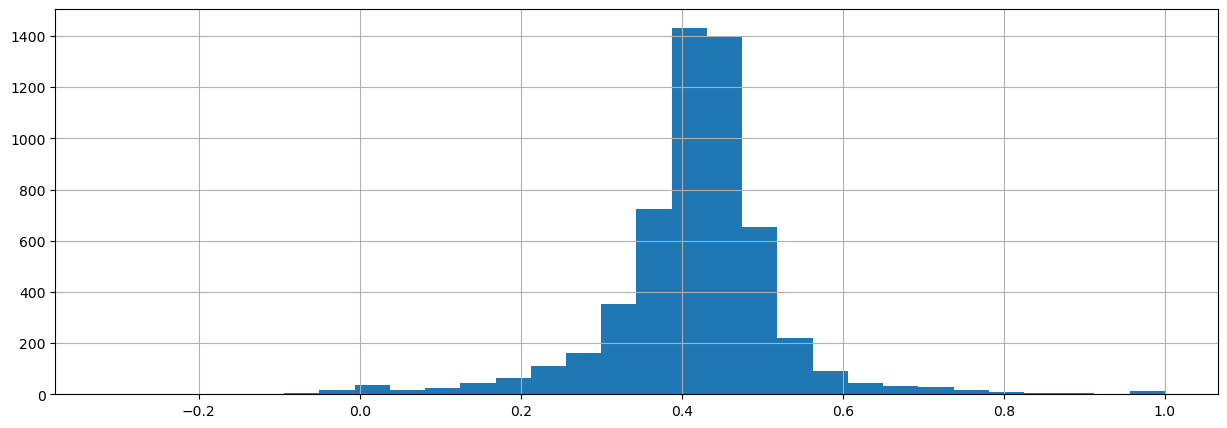

In [199]:
#check sentiment score distribution
seattle_listings_sent.avg_sentiment_score.hist(figsize=(15,5), bins=30);

## Expoloratory Analysis